In [ ]:
options(
    repr.matrix.max.rows = 10,  # smaller matrix output
    repr.plot.res = 70,         # smaller plots
    repr.plot.height = 6)       # leave room for the legend

## Interaction with the tidyverse and ggplot2

The [tidyverse](https://www.tidyverse.org/), [ggplot2](http://ggplot2.tidyverse.org/), and destiny are a great fit!

In [1]:
library(destiny)
library(tidyverse)
library(forcats)  # not in the default tidyverse loadout

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


When working mainly with dimension reductions, I suggest to hide the (useless) ticks:

In [2]:
theme_set(theme_gray() + theme(
    axis.ticks = element_blank(),
    axis.text  = element_blank()))

Let’s load our dataset

In [3]:
data(guo_norm)

Of course you could use <code>[tidyr](http://tidyr.tidyverse.org/)::[gather()](https://rdrr.io/cran/tidyr/man/gather.html)</code> to tidy or transform the data now, but the data is already in the right form for destiny, and [R for Data Science](http://r4ds.had.co.nz/tidy-data.html) is a better resource for it than this vignette. The long form of a single cell `ExpressionSet` would look like:

In [4]:
guo_norm %>%
    as('data.frame') %>%
    gather(Gene, Expression, one_of(featureNames(guo_norm)))

Cell,num_cells,Gene,Expression
2C 1.1,2,Actb,-0.575
2C 1.2,2,Actb,-0.435
2C 2.1,2,Actb,0.460
2C 2.2,2,Actb,0.610
2C 3.1,2,Actb,1.970
⋮,⋮,⋮,⋮
64C 7.10,64,Tspan8,3.220
64C 7.11,64,Tspan8,3.415
64C 7.12,64,Tspan8,4.540
64C 7.13,64,Tspan8,5.315


But destiny doesn’t use long form data as input, since all single cell data has always a more compact structure of genes×cells, with a certain number of per-sample covariates (The structure of `ExpressionSet`).

In [5]:
dm <- DiffusionMap(guo_norm)

`names(dm)` shows what names can be used in `dm$<name>`, `as.data.frame(dm)$<name>`, or `ggplot(dm, aes(<name>))`:

In [6]:
names(dm)  # namely: Diffusion Components, Genes, and Covariates

[1] "DC1"       "DC2"       "DC3"       "DC4"       "DC5"       "DC6"      
 [7] "DC7"       "DC8"       "DC9"       "DC10"      "DC11"      "DC12"     
[13] "DC13"      "DC14"      "DC15"      "DC16"      "DC17"      "DC18"     
[19] "DC19"      "DC20"      "Actb"      "Ahcy"      "Aqp3"      "Atp12a"   
[25] "Bmp4"      "Cdx2"      "Creb312"   "Cebpa"     "Dab2"      "DppaI"    
[31] "Eomes"     "Esrrb"     "Fgf4"      "Fgfr2"     "Fn1"       "Gapdh"    
[37] "Gata3"     "Gata4"     "Gata6"     "Grhl1"     "Grhl2"     "Hand1"    
[43] "Hnf4a"     "Id2"       "Klf2"      "Klf4"      "Klf5"      "Krt8"     
[49] "Lcp1"      "Mbnl3"     "Msc"       "Msx2"      "Nanog"     "Pdgfa"    
[55] "Pdgfra"    "Pecam1"    "Pou5f1"    "Runx1"     "Sox2"      "Sall4"    
[61] "Sox17"     "Snail"     "Sox13"     "Tcfap2a"   "Tcfap2c"   "Tcf23"    
[67] "Utf1"      "Tspan8"    "Cell"      "num_cells"

Due to the `fortify` method (which here just means `as.data.frame`) being defined on `DiffusionMap` objects, `ggplot` directly accepts `DiffusionMap` objects:

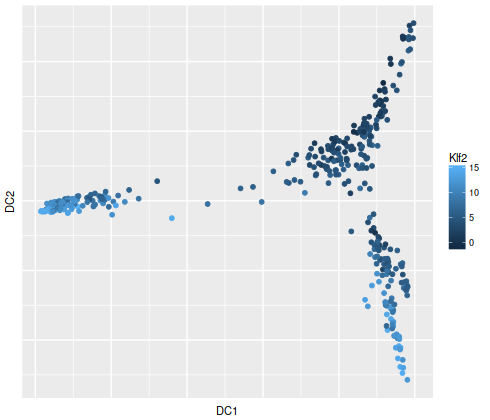

In [7]:
ggplot(dm, aes(DC1, DC2, colour = Klf2)) +
    geom_point()

When you want to use a Diffusion Map in a dplyr pipeline, you need to call `fortify`/`as.data.frame` directly:

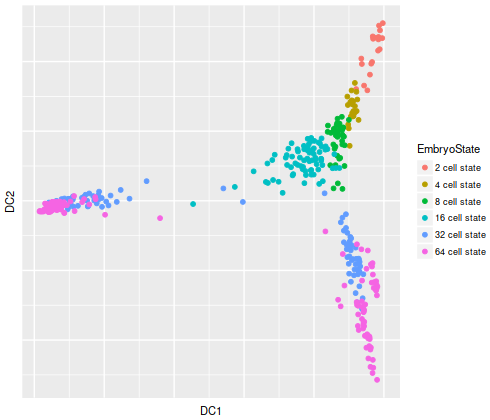

In [8]:
fortify(dm) %>%
    mutate(
        EmbryoState = factor(num_cells) %>%
            lvls_revalue(paste(levels(.), 'cell state'))
    ) %>% ggplot(aes(DC1, DC2, colour = EmbryoState)) +
        geom_point()

The Diffusion Components of a converted Diffusion Map, similar to the genes in the input `ExpressionSet`, are individual variables instead of two columns in a long-form data frame, but sometimes it can be useful to “tidy” them:

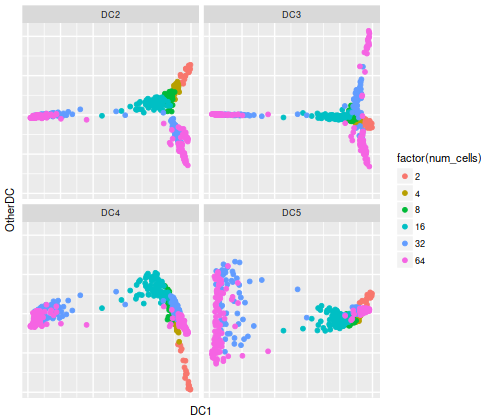

In [9]:
fortify(dm) %>%
    gather(DC, OtherDC, num_range('DC', 2:5)) %>%
    ggplot(aes(DC1, OtherDC, colour = factor(num_cells))) +
        geom_point() +
        facet_wrap(~ DC)

Another tip: To reduce overplotting, use `sample_frac(., 1.0, replace = FALSE)` (the default) in a pipeline.

Adding a constant `alpha` improves this even more, and also helps you see density:

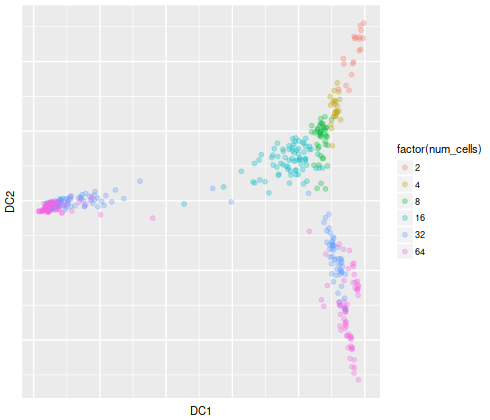

In [10]:
fortify(dm) %>%
    sample_frac %>%
    ggplot(aes(DC1, DC2, colour = factor(num_cells))) +
        geom_point(alpha = .3)